#keplar

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Step 1: Load the dataset
# Assuming the CSV file is named 'keplar.csv' and is in the working directory
df = pd.read_csv('/content/keplar.csv',comment='#')

# Step 2: Analyze the dataset
print("Dataset Info:")
print(df.info())
print("\nDataset Description:")
print(df.describe())
print("\nUnique values in target column 'koi_disposition':")
print(df['koi_disposition'].value_counts())
print("\nMissing values per column:")
print(df.isnull().sum())

# Step 3: Preprocess the data
# Drop identifier columns that are not useful for modeling
columns_to_drop = ['kepid', 'kepoi_name', 'kepler_name']  # These are unique IDs/names
df = df.drop(columns=columns_to_drop, errors='ignore')

# Target column
target = 'koi_disposition'
X = df.drop(columns=[target])
y = df[target]

# Encode the target (categorical to numerical)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

# Preprocessing pipeline for numerical data: impute missing with median, scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing pipeline for categorical data: impute missing with most frequent, one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)

# Feature Selection: Select top 20 features using mutual information
# Convert X_preprocessed to a DataFrame to retain column names for feature selection
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=preprocessor.get_feature_names_out())

selector = SelectKBest(score_func=mutual_info_classif, k=20)
X_selected = selector.fit_transform(X_preprocessed_df, y_encoded)

# Get the names of the selected features
selected_feature_names = X_preprocessed_df.columns[selector.get_support()]
print(f"\nSelected {X_selected.shape[1]} features:")
print(selected_feature_names.tolist())


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Step 4: Create an ensemble model for classification
# Define base models
model1 = LogisticRegression(max_iter=1000, random_state=42)
model2 = RandomForestClassifier(n_estimators=100, random_state=42)
model3 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
model4 = SVC(probability=True, random_state=42)

# Ensemble: Soft Voting Classifier
ensemble_model = VotingClassifier(
    estimators=[
        ('lr', model1),
        ('rf', model2),
        ('xgb', model3),
        ('svc', model4)
    ],
    voting='soft'
)

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Predict on test set
y_pred = ensemble_model.predict(X_test)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              9564 non-null   int64  
 1   kepoi_name         9564 non-null   object 
 2   kepler_name        2747 non-null   object 
 3   koi_disposition    9564 non-null   object 
 4   koi_pdisposition   9564 non-null   object 
 5   koi_score          8054 non-null   float64
 6   koi_fpflag_nt      9564 non-null   int64  
 7   koi_fpflag_ss      9564 non-null   int64  
 8   koi_fpflag_co      9564 non-null   int64  
 9   koi_fpflag_ec      9564 non-null   int64  
 10  koi_period         9564 non-null   float64
 11  koi_period_err1    9110 non-null   float64
 12  koi_period_err2    9110 non-null   float64
 13  koi_time0bk        9564 non-null   float64
 14  koi_time0bk_err1   9110 non-null   float64
 15  koi_time0bk_err2   9110 non-null   float64
 16  koi_impact

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['koi_teq_err1' 'koi_teq_err2']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(



Selected 20 features:
['num__koi_score', 'num__koi_fpflag_nt', 'num__koi_fpflag_ss', 'num__koi_fpflag_co', 'num__koi_period', 'num__koi_period_err1', 'num__koi_period_err2', 'num__koi_time0bk_err1', 'num__koi_time0bk_err2', 'num__koi_duration_err1', 'num__koi_duration_err2', 'num__koi_depth', 'num__koi_prad', 'num__koi_prad_err1', 'num__koi_prad_err2', 'num__koi_model_snr', 'num__koi_steff_err1', 'num__koi_steff_err2', 'cat__koi_pdisposition_CANDIDATE', 'cat__koi_pdisposition_FALSE POSITIVE']


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:02:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report:
                precision    recall  f1-score   support

     CANDIDATE       0.87      0.81      0.84       396
     CONFIRMED       0.87      0.91      0.89       549
FALSE POSITIVE       1.00      1.00      1.00       968

      accuracy                           0.94      1913
     macro avg       0.91      0.91      0.91      1913
  weighted avg       0.94      0.94      0.94      1913


Accuracy Score:
0.9362258233141663



Confusion Matrix:
[[321  75   0]
 [ 46 502   1]
 [  0   0 968]]


<Figure size 800x600 with 0 Axes>

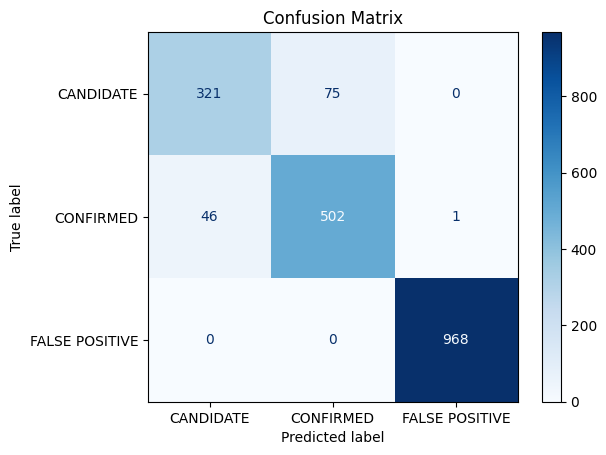

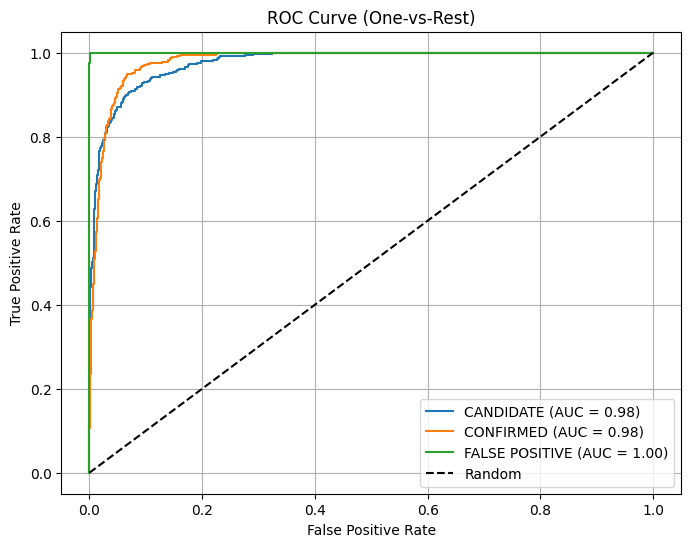


Evaluation results saved to '/content/drive/My Drive/nasa/ensemble_model_results_keplar/keplar_evaluation_results.txt'
ROC curve plot saved to '/content/drive/My Drive/nasa/ensemble_model_results_keplar/keplar_roc_curve.png'
Confusion matrix plot saved to '/content/drive/My Drive/nasa/ensemble_model_results_keplar/keplar_confusion_matrix.png'


<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os
import joblib
from google.colab import drive

# Evaluate the model further
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot and save Confusion Matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


# Calculate ROC curve and AUC for each class
# Since this is a multi-class problem, we need to calculate ROC for each class using one-vs-rest
y_test_bin = pd.get_dummies(y_test, prefix='disposition') # Convert y_test to binary
y_pred_proba = ensemble_model.predict_proba(X_test)

plt.figure(figsize=(8, 6))
for i, class_name in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin.iloc[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend()
plt.grid(True)
plt.show()


# Save the evaluation results to Google Drive
#drive.mount('/content/drive')

results_folder_path = '/content/drive/My Drive/nasa/ensemble_model_results_keplar'
if not os.path.exists(results_folder_path):
    os.makedirs(results_folder_path)
    print(f"Created folder: {results_folder_path}")

results_file_path = os.path.join(results_folder_path, 'keplar_evaluation_results.txt')
roc_curve_path = os.path.join(results_folder_path, 'keplar_roc_curve.png')
confusion_matrix_path = os.path.join(results_folder_path, 'keplar_confusion_matrix.png')


with open(results_file_path, 'w') as f:
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred, target_names=le.classes_))
    f.write("\n\nAccuracy Score:\n")
    f.write(str(accuracy_score(y_test, y_pred)))
    # Confusion matrix is saved as an image now, not text
    # f.write("\n\nConfusion Matrix:\n")
    # f.write(str(confusion_matrix(y_test, y_pred)))

print(f"\nEvaluation results saved to '{results_file_path}'")

# Save the ROC curve plot
plt.figure() # Create a new figure for the ROC plot before saving
for i, class_name in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin.iloc[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend()
plt.grid(True)
plt.savefig(roc_curve_path)
print(f"ROC curve plot saved to '{roc_curve_path}'")
plt.close() # Close the figure to free up memory


# Save the Confusion Matrix plot
plt.figure() # Create a new figure for the confusion matrix plot before saving
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig(confusion_matrix_path)
print(f"Confusion matrix plot saved to '{confusion_matrix_path}'")
plt.close() # Close the figure to free up memory

In [ ]:
# Step 5: Save the model to Google Drive
from google.colab import drive
import os
import joblib

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the folder and the model file
folder_path = '/content/drive/My Drive/nasa'
model_path = os.path.join(folder_path, 'ensemble_model.pkl')
preprocessor_path = os.path.join(folder_path, 'preprocessor.pkl')
label_encoder_path = os.path.join(folder_path, 'label_encoder.pkl')
selector_path = os.path.join(folder_path, 'selector.pkl')


# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' created.")

# Save the model
joblib.dump(ensemble_model, model_path)
print(f"Model saved successfully to '{model_path}'")

# Save the preprocessor
joblib.dump(preprocessor, preprocessor_path)
print(f"Preprocessor saved successfully to '{preprocessor_path}'")

# Save the label encoder
joblib.dump(le, label_encoder_path)
print(f"Label encoder saved successfully to '{label_encoder_path}'")

# Save the selector
joblib.dump(selector, selector_path)
print(f"Selector saved successfully to '{selector_path}'")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved successfully to '/content/drive/My Drive/nasa/ensemble_model.pkl'
Preprocessor saved successfully to '/content/drive/My Drive/nasa/preprocessor.pkl'
Label encoder saved successfully to '/content/drive/My Drive/nasa/label_encoder.pkl'
Selector saved successfully to '/content/drive/My Drive/nasa/selector.pkl'


##TESTING

In [ ]:
import joblib
import pandas as pd
import numpy as np
import sys

path ="/content/drive/MyDrive/nasa/"

# Load the saved objects
try:
    ensemble_model = joblib.load(path+'ensemble_model.pkl')
    preprocessor = joblib.load(path+'preprocessor.pkl')
    le = joblib.load(path+'label_encoder.pkl')
    # Load the selector object
    selector = joblib.load(path+'selector.pkl')
except FileNotFoundError as e:
    print(f"Error: Missing file - {e}")
    sys.exit(1)
except Exception as e:
    print(f"Error loading files: {e}")
    sys.exit(1)

# Define the full list of expected features based on the preprocessor
try:
    numerical_features_expected = preprocessor.named_transformers_['num'].named_steps['imputer'].feature_names_in_
    categorical_features_expected = preprocessor.named_transformers_['cat'].named_steps['imputer'].feature_names_in_
    all_cols_expected = list(numerical_features_expected) + list(categorical_features_expected)
except Exception as e:
    print(f"Error retrieving expected feature names from preprocessor: {e}")
    sys.exit(1)

# Function to get user input for a feature
def get_input(feature, is_numerical):
    while True:
        value = input(f"Enter value for {feature} (leave empty for missing): ").strip()
        if value == '':
            return np.nan if is_numerical else None # Use None for missing categorical
        if is_numerical:
            try:
                return float(value)
            except ValueError:
                print("Invalid number. Please enter a valid float or leave empty.")
        else:
            return value

# Collect inputs for all expected features
input_data = {}
print("Please provide inputs for each feature. Press enter for missing values.")
for col in all_cols_expected:
    is_num = col in numerical_features_expected
    input_data[col] = get_input(col, is_num)

# Create DataFrame, ensuring all expected columns are present
input_df = pd.DataFrame([input_data])

# Preprocess the input data (apply imputer and scaler)
try:
    input_preprocessed = preprocessor.transform(input_df)
    input_preprocessed_df = pd.DataFrame(input_preprocessed, columns=preprocessor.get_feature_names_out())
except Exception as e:
    print(f"Error during preprocessing: {e}")
    sys.exit(1)

# Apply feature selection using the loaded selector
try:
    input_selected = selector.transform(input_preprocessed_df)
except Exception as e:
    print(f"Error during feature selection: {e}")
    sys.exit(1)


# Predict
try:
    prediction = ensemble_model.predict(input_selected)
    prediction_proba = ensemble_model.predict_proba(input_selected)
    predicted_label = le.inverse_transform(prediction)[0]

    print(f"\nPredicted Disposition: {predicted_label}")
    print("Prediction Probabilities:")
    for cls, prob in zip(le.classes_, prediction_proba[0]):
        print(f"{cls}: {prob:.4f}")
except Exception as e:
    print(f"Error during prediction: {e}")

#K2

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Step 1: Load the data
df = pd.read_csv("/content/k2.csv",comment='#',low_memory=False)  # Adjust path if needed

# Step 2: Handle multi-entries per planet (select default_flag == 1)
df = df.sort_values(by=['pl_name', 'default_flag'], ascending=[True, False])
df = df.drop_duplicates(subset='pl_name', keep='first')  # Keeps the one with highest default_flag

# Step 3: Feature Selection
# Target
target = 'disposition'
y = df[target].map({'CONFIRMED': 1, 'CANDIDATE': 0})  # Binary: 1=CONFIRMED, 0=CANDIDATE

# Handle missing values in the target variable by dropping rows with NaN
y = y.dropna()
X = df.loc[y.index, :] # Ensure X corresponds to the cleaned y


# Features: Select relevant numerical and categorical
numerical_features = [
    'pl_orbper', 'pl_rade', 'pl_bmasse', 'st_teff', 'st_rad', 'st_mass',
    'sy_dist', 'sy_vmag', 'sy_kmag', 'sy_gaiamag'
]
categorical_features = ['disc_facility', 'st_spectype', 'st_metratio']

X = X[numerical_features + categorical_features]


# Drop columns with >50% missing
missing_perc = X.isnull().mean()
X = X.loc[:, missing_perc < 0.5]

# Update feature lists after dropping
numerical_features = [col for col in numerical_features if col in X.columns]
categorical_features = [col for col in categorical_features if col in X.columns]

# Step 4: Preprocessing Pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing with median
    ('scaler', StandardScaler())  # Standardize
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute with mode
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)

# Step 5: Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42, stratify=y)

# Output shapes
print("Preprocessed X_train shape:", X_train.shape)
print("Preprocessed X_test shape:", X_test.shape)
print("y_train distribution:", y_train.value_counts())
print("y_test distribution:", y_test.value_counts())

# Optionally save preprocessed data
pd.DataFrame(X_preprocessed).to_csv('preprocessed_data.csv', index=False)
pd.Series(y).to_csv('labels.csv', index=False)

Preprocessed X_train shape: (1244, 19)
Preprocessed X_test shape: (312, 19)
y_train distribution: disposition
0.0    780
1.0    464
Name: count, dtype: int64
y_test distribution: disposition
0.0    196
1.0    116
Name: count, dtype: int64


In [ ]:
X_preprocessed.shape

(1556, 19)

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming X_train, X_test, y_train, y_test from preprocessing

# Individual models
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
svc = SVC(probability=True, random_state=42, class_weight='balanced')

# Ensemble: Voting Classifier
ensemble = VotingClassifier(
    estimators=[('rf', rf), ('gb', gb), ('svc', svc)],
    voting='soft'  # Soft voting uses probabilities
)

# Train
ensemble.fit(X_train, y_train)

# Predict and evaluate
y_pred = ensemble.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9006410256410257
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.93      0.92       196
         1.0       0.88      0.84      0.86       116

    accuracy                           0.90       312
   macro avg       0.90      0.89      0.89       312
weighted avg       0.90      0.90      0.90       312

Confusion Matrix:
 [[183  13]
 [ 18  98]]


In [ ]:
import pandas as pd
import joblib

path = "/content/drive/MyDrive/nasa/"

# Load the saved preprocessor
try:
    preprocessor = joblib.load(path + 'preprocessor_k2.pkl')
except FileNotFoundError as e:
    print(f"Error: Missing preprocessor file - {e}")
except Exception as e:
    print(f"Error loading preprocessor: {e}")

# Get the feature names from the preprocessor
# This can be a bit tricky depending on the preprocessor structure
# Assuming the column transformer has named steps 'num' and 'cat'

numerical_features_trained = preprocessor.named_transformers_['num'].named_steps['imputer'].feature_names_in_
categorical_features_trained = preprocessor.named_transformers_['cat'].named_steps['imputer'].feature_names_in_

print("Expected Input Features and Data Types:")
print("\nNumerical Features:")
for feature in numerical_features_trained:
    print(f"- {feature}: float")

print("\nCategorical Features:")
for feature in categorical_features_trained:
    print(f"- {feature}: object (string)")

print("\nExample Input Dictionary:")
# Create a sample dictionary with placeholder values
example_input = {}
for feature in numerical_features_trained:
    example_input[feature] = 0.0  # Placeholder for numerical features
for feature in categorical_features_trained:
    example_input[feature] = "example_value" # Placeholder for categorical features

print(example_input)

Expected Input Features and Data Types:

Numerical Features:
- pl_orbper: float
- pl_rade: float
- st_teff: float
- st_rad: float
- st_mass: float
- sy_dist: float
- sy_vmag: float
- sy_kmag: float
- sy_gaiamag: float

Categorical Features:
- disc_facility: object (string)

Example Input Dictionary:
{'pl_orbper': 0.0, 'pl_rade': 0.0, 'st_teff': 0.0, 'st_rad': 0.0, 'st_mass': 0.0, 'sy_dist': 0.0, 'sy_vmag': 0.0, 'sy_kmag': 0.0, 'sy_gaiamag': 0.0, 'disc_facility': 'example_value'}



Confusion Matrix:
[[183  13]
 [ 18  98]]


<Figure size 800x600 with 0 Axes>

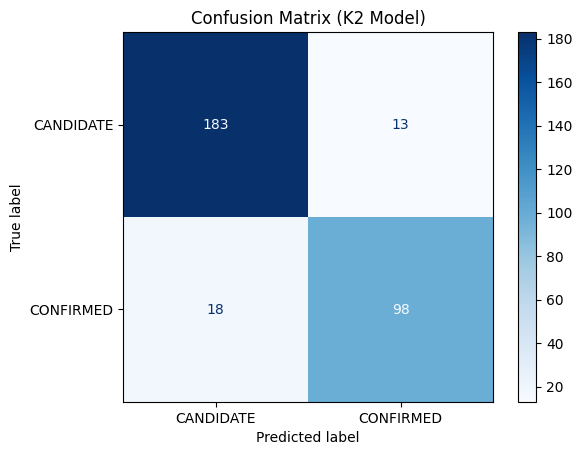

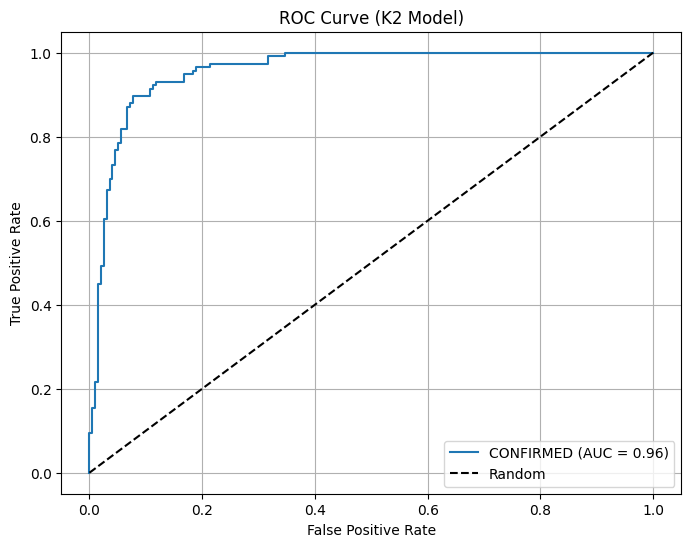

Created folder: /content/drive/My Drive/nasa/ensemble_model_results_k2

Evaluation results saved to '/content/drive/My Drive/nasa/ensemble_model_results_k2/k2_evaluation_results.txt'
ROC curve plot saved to '/content/drive/My Drive/nasa/ensemble_model_results_k2/k2_roc_curve.png'
Confusion matrix plot saved to '/content/drive/My Drive/nasa/ensemble_model_results_k2/k2_confusion_matrix.png'


<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os
from google.colab import drive
import pandas as pd
import joblib

# Assuming y_test, y_pred, and the trained 'ensemble' model are available from the previous cells

# Evaluate the model further
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# **FIX:** Manually define the correct class labels for the binary K2 model
class_labels_k2 = ['CANDIDATE', 'CONFIRMED']

# Plot and save Confusion Matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels_k2)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (K2 Model)')
plt.show()


# Get prediction probabilities for the positive class (CONFIRMED)
y_pred_proba = ensemble.predict_proba(X_test)[:, 1]

plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
# Use the correct label for the ROC curve
plt.plot(fpr, tpr, label=f'{class_labels_k2[1]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (K2 Model)')
plt.legend()
plt.grid(True)
plt.show()


# Save the evaluation results to Google Drive
results_folder_path = '/content/drive/My Drive/nasa/ensemble_model_results_k2'
if not os.path.exists(results_folder_path):
    os.makedirs(results_folder_path)
    print(f"Created folder: {results_folder_path}")

results_file_path = os.path.join(results_folder_path, 'k2_evaluation_results.txt')
roc_curve_path = os.path.join(results_folder_path, 'k2_roc_curve.png')
confusion_matrix_path = os.path.join(results_folder_path, 'k2_confusion_matrix.png')


with open(results_file_path, 'w') as f:
    f.write("Classification Report (K2 Model):\n")
    # Use the correct target names in the classification report
    f.write(classification_report(y_test, y_pred, target_names=class_labels_k2, zero_division=0))
    f.write("\n\nAccuracy Score (K2 Model):\n")
    f.write(str(accuracy_score(y_test, y_pred)))

print(f"\nEvaluation results saved to '{results_file_path}'")

# Save the ROC curve plot
plt.figure()
plt.plot(fpr, tpr, label=f'{class_labels_k2[1]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (K2 Model)')
plt.legend()
plt.grid(True)
plt.savefig(roc_curve_path)
print(f"ROC curve plot saved to '{roc_curve_path}'")
plt.close()


# Save the Confusion Matrix plot
plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels_k2)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (K2 Model)')
plt.savefig(confusion_matrix_path)
print(f"Confusion matrix plot saved to '{confusion_matrix_path}'")
plt.close()

In [ ]:
# Step 5: Save the model to Google Drive
from google.colab import drive
import os
import joblib

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the folder and the model file
folder_path = '/content/drive/My Drive/nasa'
model_path = os.path.join(folder_path, 'ensemble_model_k2.pkl')
preprocessor_path = os.path.join(folder_path, 'preprocessor_k2.pkl')
label_encoder_path = os.path.join(folder_path, 'label_encoder_k2.pkl')


# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' created.")

# Save the model
joblib.dump(ensemble, model_path)
print(f"Model saved successfully to '{model_path}'")

# Save the preprocessor
joblib.dump(preprocessor, preprocessor_path)
print(f"Preprocessor saved successfully to '{preprocessor_path}'")

# Save the label encoder
joblib.dump(le, label_encoder_path)
print(f"Label encoder saved successfully to '{label_encoder_path}'")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved successfully to '/content/drive/My Drive/nasa/ensemble_model_k2.pkl'
Preprocessor saved successfully to '/content/drive/My Drive/nasa/preprocessor_k2.pkl'
Label encoder saved successfully to '/content/drive/My Drive/nasa/label_encoder_k2.pkl'


##TESTING

In [ ]:
import joblib
import pandas as pd
import numpy as np # Import numpy for handling potential NaN values
import sys

path = "/content/drive/MyDrive/nasa/"

# Load the saved model and preprocessor
try:
    ensemble = joblib.load(path + 'ensemble_model_k2.pkl')
    preprocessor = joblib.load(path + 'preprocessor_k2.pkl')
    le = joblib.load(path + 'label_encoder_k2.pkl')  # Load label encoder
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    sys.exit(1)
except Exception as e:
    print(f"An unexpected error occurred during file loading: {e}")
    sys.exit(1)

# Get the feature names the preprocessor expects
try:
    # The ColumnTransformer expects features based on its fitted state.
    # We can get the expected input feature names from the preprocessor itself.
    # Note: This assumes the preprocessor was fitted on a DataFrame or has access to feature names.
    # If the preprocessor was fitted on a numpy array without feature names, this will fail.
    # Based on the training code (cell ooF73weOWag4), the preprocessor was fitted on DataFrame X.
    numerical_features_expected = preprocessor.named_transformers_['num'].named_steps['imputer'].feature_names_in_
    categorical_features_expected = preprocessor.named_transformers_['cat'].named_steps['imputer'].feature_names_in_
    all_features_expected = list(numerical_features_expected) + list(categorical_features_expected)

except Exception as e:
    print(f"Error retrieving expected feature names from preprocessor: {e}")
    sys.exit(1)


# Feature descriptions for user input
feature_descriptions = {
    'pl_orbper': "Orbital period of the planet in days (e.g., 4.465)",
    'pl_rade': "Planet radius in Earth radii (e.g., 2.03)",
    'pl_bmasse': "Planet mass in Earth masses (e.g., 6.26)",
    'st_teff': "Stellar effective temperature in Kelvin (e.g., 4716)",
    'st_rad': "Stellar radius in Solar radii (e.g., 0.689)",
    'st_mass': "Stellar mass in Solar masses (e.g., 0.688)",
    'sy_dist': "System distance in parsecs (e.g., 44.526)",
    'sy_vmag': "V (Johnson) magnitude (e.g., 10.27)",
    'sy_kmag': "Ks (2MASS) magnitude (e.g., 7.617)",
    'sy_gaiamag': "Gaia magnitude (e.g., 9.898)",
    'disc_facility': "Discovery facility (e.g., 'K2' or 'SuperWASP')",
    'st_spectype': "Stellar spectral type (e.g., 'K3.5 V' or 'F9')",
    'st_metratio': "Stellar metallicity ratio (e.g., '[Fe/H]' or '[M/H]')"
}


# Collect inputs for all expected features
input_dict = {}
print("Please provide inputs for the following features. Press enter for missing values.")
for feature in all_features_expected:
    description = feature_descriptions.get(feature, f"Value for {feature}")
    is_numerical = feature in numerical_features_expected

    while True:
        value_str = input(f"Enter {description} (leave empty for missing): ").strip()
        if value_str == '':
            input_dict[feature] = np.nan if is_numerical else None # Use None for missing categorical
            break
        if is_numerical:
            try:
                input_dict[feature] = float(value_str)
                break
            except ValueError:
                print("Invalid input. Please enter a valid number or leave empty.")
        else:
            input_dict[feature] = value_str
            break

# Create DataFrame with collected inputs
# Ensure the columns are in the order expected by the preprocessor
input_df = pd.DataFrame([input_dict])

# Reindex the DataFrame to ensure all expected columns are present, filling missing with NaN
input_df = input_df.reindex(columns=all_features_expected)


# Preprocess the input data
try:
    # Apply the preprocessor to the input DataFrame
    input_preprocessed = preprocessor.transform(input_df)
except Exception as e:
    print(f"Error during preprocessing: {e}")
    sys.exit(1)

# Predict
try:
    prediction = ensemble.predict(input_preprocessed)[0]
    # Use the loaded label encoder to get the original label
    predicted_label = le.inverse_transform([int(prediction)])[0]


    # Get prediction probabilities
    prediction_proba = ensemble.predict_proba(input_preprocessed)[0]
    print(f"\nPredicted Disposition: {predicted_label}")
    print("Prediction Probabilities:")
    # Assuming the order of probabilities matches the order of classes in le.classes_
    for class_name, prob in zip(le.classes_, prediction_proba):
        print(f"{class_name}: {prob:.4f}")

except Exception as e:
    print(f"Error during prediction: {e}")
    # Handle prediction errors
    # sys.exit(1) # If sys is imported and you want to exit

Please provide inputs for the following features. Press enter for missing values.
Enter Orbital period of the planet in days (e.g., 4.465) (leave empty for missing): 4.56
Enter Planet radius in Earth radii (e.g., 2.03) (leave empty for missing): 2.03
Enter Stellar effective temperature in Kelvin (e.g., 4716) (leave empty for missing): 4567
Enter Stellar radius in Solar radii (e.g., 0.689) (leave empty for missing): 0.55
Enter Stellar mass in Solar masses (e.g., 0.688) (leave empty for missing): 0.643
Enter System distance in parsecs (e.g., 44.526) (leave empty for missing): 44.678
Enter V (Johnson) magnitude (e.g., 10.27) (leave empty for missing): 10.345
Enter Ks (2MASS) magnitude (e.g., 7.617) (leave empty for missing): 7.543
Enter Gaia magnitude (e.g., 9.898) (leave empty for missing): 9.875
Enter Discovery facility (e.g., 'K2' or 'SuperWASP') (leave empty for missing): K2

Predicted Disposition: CONFIRMED
Prediction Probabilities:
CANDIDATE: 0.1450
CONFIRMED: 0.8550


#TESS

In [10]:
import pandas as pd
import numpy as np
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Note: In a real scenario, replace the 'data' string with the full CSV content or load from file.
# Here, using the provided truncated data for demonstration.


# Load the data (use pd.read_csv('filename.csv', comment='#') if loading from file)
# Correcting the file path
try:
    df = pd.read_csv('/content/TOI.csv', comment='#')
except FileNotFoundError:
    print("Error: The file '/content/TOI_2025.10.03_22.43.57.csv' was not found.")
    print("Please upload the file to the Colab environment or provide the correct path.")
    # Exit or handle the error appropriately if the file is not found
    raise # Re-raise the exception to stop execution

# Analyze the dataset
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:\n", df.head())
print("\nData Types:\n", df.dtypes)
print("\nMissing Values Count:\n", df.isnull().sum())
print("\nUnique Dispositions:\n", df['tfopwg_disp'].unique())
print("\nDisposition Distribution:\n", df['tfopwg_disp'].value_counts())

# Preprocess the data
# Drop unnecessary columns
drop_cols = ['toi', 'tid', 'rastr', 'decstr', 'toi_created', 'rowupdate']
df = df.drop(columns=drop_cols, errors='ignore')

# Target column
target = 'tfopwg_disp'

# Encode the target
le = LabelEncoder()
df[target] = le.fit_transform(df[target])
print("\nEncoded Classes:", le.classes_)

# Separate features and target
X = df.drop(columns=[target])
y = df[target]

# Convert to numeric
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Drop columns with all missing values
X = X.dropna(axis=1, how='all')
print(f"\nShape after dropping all-NaN columns: {X.shape}")

# Save the list of features after dropping all-NaN columns
imputer_feature_names_tess = X.columns.tolist()

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Get the feature names after imputation (should be the same as imputer_feature_names_tess)
feature_names = imputer.get_feature_names_out(X.columns)

X_imputed = pd.DataFrame(X_imputed, columns=feature_names)

# Feature Selection: Select top 20 features using mutual information
selector = SelectKBest(score_func=mutual_info_classif, k=20)
X_selected = selector.fit_transform(X_imputed, y)

# Get the names of the selected features
selected_feature_names_tess = X_imputed.columns[selector.get_support()]
X_selected = pd.DataFrame(X_selected, columns=selected_feature_names_tess)

print(f"\nSelected {X_selected.shape[1]} features:")
print(selected_feature_names_tess.tolist())


# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Split data (without stratify due to class imbalance)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create ensemble model
clf1 = LogisticRegression(max_iter=1000, random_state=42)
clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf3 = GradientBoostingClassifier(n_estimators=100, random_state=42)

ensemble_tess = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gb', clf3)], voting='soft')

# Train
ensemble_tess.fit(X_train, y_train)

# Evaluate
y_pred = ensemble_tess.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

Dataset Shape: (7703, 65)

First 5 rows:
        toi        tid tfopwg_disp         rastr          ra         decstr  \
0  1000.01   50365310          FP  07h29m25.85s  112.357708  -12d41m45.46s   
1  1001.01   88863718          PC  08h10m19.31s  122.580465  -05d30m49.87s   
2  1002.01  124709665          FP  06h58m54.47s  104.726966  -10d34m49.64s   
3  1003.01  106997505          FP  07h22m14.39s  110.559945  -25d12m25.26s   
4  1004.01  238597883          FP  08h08m42.77s  122.178195  -48d48m10.12s   

         dec  st_pmra  st_pmraerr1  st_pmraerr2  ...  st_logg  st_loggerr1  \
0 -12.695960   -5.964        0.085       -0.085  ...     4.19         0.07   
1  -5.513852   -4.956        0.102       -0.102  ...     4.03         0.09   
2 -10.580455   -1.462        0.206       -0.206  ...      NaN          NaN   
3 -25.207017   -0.939        0.041       -0.041  ...     4.15         1.64   
4 -48.802811   -4.496        0.069       -0.069  ...     4.14         0.07   

   st_loggerr2  st_l

In [11]:
# Step 5: Save the model to Google Drive
from google.colab import drive
import os
import joblib

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the folder and the model file
folder_path = '/content/drive/My Drive/nasa'
model_path = os.path.join(folder_path, 'ensemble_model_TESS.pkl')
preprocessor_path = os.path.join(folder_path, 'preprocessor_TESS.pkl')
label_encoder_path = os.path.join(folder_path, 'label_encoder_TESS.pkl')
imputer_feature_names_path = os.path.join(folder_path, 'imputer_feature_names_TESS.pkl')
selected_feature_names_path = os.path.join(folder_path, 'selected_feature_names_TESS.pkl')

# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' created.")

# Save the model
joblib.dump(ensemble_tess, model_path)
print(f"Model saved successfully to '{model_path}'")

# Save the preprocessor
#joblib.dump(preprocessor, preprocessor_path)
#print(f"Preprocessor saved successfully to '{preprocessor_path}'")

# Save the label encoder
joblib.dump(le, label_encoder_path)
print(f"Label encoder saved successfully to '{label_encoder_path}'")

# Save the list of feature names the imputer was trained on
joblib.dump(imputer_feature_names_tess, imputer_feature_names_path)
print(f"Imputer feature names saved successfully to '{imputer_feature_names_path}'")

# Save the list of selected feature names
joblib.dump(selected_feature_names_tess.tolist(), selected_feature_names_path)
print(f"Selected feature names saved successfully to '{selected_feature_names_path}'")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved successfully to '/content/drive/My Drive/nasa/ensemble_model_TESS.pkl'
Label encoder saved successfully to '/content/drive/My Drive/nasa/label_encoder_TESS.pkl'
Imputer feature names saved successfully to '/content/drive/My Drive/nasa/imputer_feature_names_TESS.pkl'
Selected feature names saved successfully to '/content/drive/My Drive/nasa/selected_feature_names_TESS.pkl'


In [12]:
import joblib

path = "/content/drive/MyDrive/nasa/"

joblib.dump(imputer, path+'imputer_TESS.pkl')
joblib.dump(scaler, path+'scaler_TESS.pkl')

['/content/drive/MyDrive/nasa/scaler_TESS.pkl']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Label encoder for TESS loaded successfully.

Confusion Matrix:
[[  3   0   0  16   2  69]
 [  1  41   0   7   6  90]
 [  0   0   1   3   0  17]
 [  4   3   1  90   3 153]
 [  0   4   0   1  36  72]
 [  0   8   1  29   5 875]]


<Figure size 1000x800 with 0 Axes>

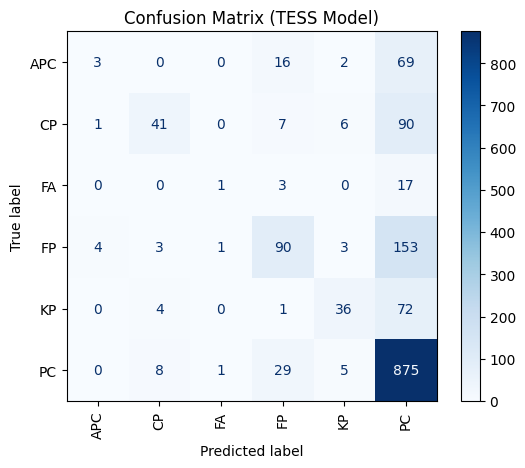

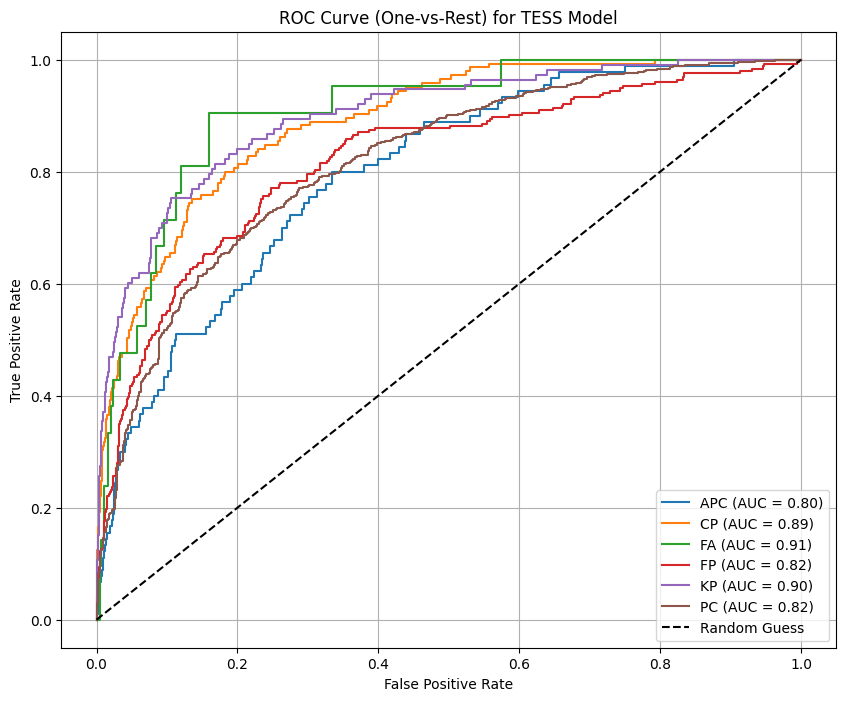


Evaluation results saved to '/content/drive/My Drive/nasa/ensemble_model_results_tess/tess_evaluation_results.txt'
ROC curve plot saved to '/content/drive/My Drive/nasa/ensemble_model_results_tess/tess_roc_curve.png'
Confusion matrix plot saved to '/content/drive/My Drive/nasa/ensemble_model_results_tess/tess_confusion_matrix.png'


<Figure size 1000x800 with 0 Axes>

In [13]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, accuracy_score, classification_report
import matplotlib.pyplot as plt
import os
import joblib
import pandas as pd
from google.colab import drive

# Ensure Google Drive is mounted
drive.mount('/content/drive')

# --- Assume y_test, y_pred, and the trained 'ensemble_tess' model are available from the previous cell ---

# Load the label encoder saved for the TESS model
path = "/content/drive/My Drive/nasa/"
try:
    le_tess = joblib.load(path + 'label_encoder_TESS.pkl')
    print("Label encoder for TESS loaded successfully.")
except FileNotFoundError:
    print(f"Error: Label encoder file not found at {path + 'label_encoder_TESS.pkl'}")
    # Fallback if the file is missing
    le_tess = None
except Exception as e:
    print(f"Error loading label encoder: {e}")
    le_tess = None

# Get the class labels from the loaded label encoder for TESS
class_labels_tess = le_tess.classes_ if le_tess else [str(i) for i in range(len(set(y_test)))]


# 1. Generate and Plot Confusion Matrix
# ----------------------------------------
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot and display the Confusion Matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels_tess)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix (TESS Model)')
plt.show()


# 2. Generate and Plot ROC Curve (One-vs-Rest for Multi-Class)
# -----------------------------------------------------------------
# Get prediction probabilities
y_pred_proba = ensemble_tess.predict_proba(X_test)

# One-hot encode the true labels to compare against probabilities
y_test_bin = pd.get_dummies(y_test)

# Set up the plot
plt.figure(figsize=(10, 8))

# Calculate and plot ROC curve for each class
for i, class_name in enumerate(class_labels_tess):
    fpr, tpr, _ = roc_curve(y_test_bin.iloc[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest) for TESS Model')
plt.legend()
plt.grid(True)
plt.show()


# 3. Save Evaluation Results and Plots to Google Drive
# -------------------------------------------------------
results_folder_path = '/content/drive/My Drive/nasa/ensemble_model_results_tess'
if not os.path.exists(results_folder_path):
    os.makedirs(results_folder_path)
    print(f"Created folder: {results_folder_path}")

results_file_path = os.path.join(results_folder_path, 'tess_evaluation_results.txt')
roc_curve_path = os.path.join(results_folder_path, 'tess_roc_curve.png')
confusion_matrix_path = os.path.join(results_folder_path, 'tess_confusion_matrix.png')

# Save text report
with open(results_file_path, 'w') as f:
    f.write("Classification Report (TESS Model):\n")
    f.write(classification_report(y_test, y_pred, target_names=class_labels_tess, zero_division=0))
    f.write("\n\nAccuracy Score (TESS Model):\n")
    f.write(str(accuracy_score(y_test, y_pred)))

print(f"\nEvaluation results saved to '{results_file_path}'")

# Save the ROC curve plot
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_labels_tess):
    fpr, tpr, _ = roc_curve(y_test_bin.iloc[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest) for TESS Model')
plt.legend()
plt.grid(True)
plt.savefig(roc_curve_path)
plt.close()
print(f"ROC curve plot saved to '{roc_curve_path}'")

# Save the Confusion Matrix plot
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels_tess)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix (TESS Model)')
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.savefig(confusion_matrix_path)
plt.close()
print(f"Confusion matrix plot saved to '{confusion_matrix_path}'")

##Test

In [ ]:
# New script for loading the model and predicting:

import pandas as pd
import joblib
import numpy as np # Import numpy for handling potential NaN values

path ="/content/drive/MyDrive/nasa/"

# Load preprocessors and model
try:
    imputer = joblib.load(path+'imputer_TESS.pkl')
    scaler = joblib.load(path+'scaler_TESS.pkl')
    model = joblib.load(path+'ensemble_model_TESS.pkl')
    le = joblib.load(path+'label_encoder_TESS.pkl') # Load the correct label encoder for TESS
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    # Exit or handle the error appropriately if files are not found
    # sys.exit(1) # If sys is imported and you want to exit
except Exception as e:
    print(f"An unexpected error occurred during file loading: {e}")
    # Handle other potential loading errors
    # sys.exit(1) # If sys is imported and you want to exit


# Get the expected feature names from the imputer and scaler
# Assuming the imputer was fitted on the data *after* dropping all-NaN columns
try:
    # The imputer was fitted on X *after* dropping all-NaN columns
    # The scaler was fitted on X_selected
    # We need the features that the scaler was fitted on (the 20 selected features)
    # Since the scaler was fitted on a numpy array (X_selected), we don't have direct feature names.
    # We need to reconstruct the feature names from the training process or save the selected feature names.
    # For now, we'll manually list the selected features based on the output of the training cell.
    # This is a temporary solution; saving the list of selected features during training is better practice.

    # Based on the output of the training cell:
    selected_feature_names = ['st_pmra', 'pl_tranmid', 'pl_trandurherr1', 'pl_trandurherr2', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_eqt', 'st_tmag', 'st_dist', 'st_disterr1', 'st_disterr2', 'st_tefferr1', 'st_tefferr2', 'st_logg', 'st_loggerr1', 'st_loggerr2', 'st_rad', 'st_raderr1', 'st_raderr2']


except Exception as e:
    print(f"Error retrieving expected feature names: {e}")
    # Handle error if feature names cannot be retrieved
    # sys.exit(1) # If sys is imported and you want to exit


# Feature names and descriptions for the selected features
feature_descriptions = {
    'st_pmra': 'PMRA [mas/yr]',
    'pl_tranmid': 'Planet Transit Midpoint Value [BJD]',
    'pl_trandurherr1': 'Planet Transit Duration Upper Unc [hours]',
    'pl_trandurherr2': 'Planet Transit Duration Lower Unc [hours]',
    'pl_rade': 'Planet Radius Value [R_Earth]',
    'pl_radeerr1': 'Planet Radius Upper Unc [R_Earth]',
    'pl_radeerr2': 'Planet Radius Lower Unc [R_Earth]',
    'pl_eqt': 'Planet Equilibrium Temperature Value [K]',
    'st_tmag': 'TESS Magnitude',
    'st_dist': 'Stellar Distance [pc]',
    'st_disterr1': 'Stellar Distance Upper Unc [pc]',
    'st_disterr2': 'Stellar Distance Lower Unc [pc]',
    'st_tefferr1': 'Stellar Effective Temperature Upper Unc [K]',
    'st_tefferr2': 'Stellar Effective Temperature Lower Unc [K]',
    'st_logg': 'Stellar log(g) Value [cm/s**2]',
    'st_loggerr1': 'Stellar log(g) Upper Unc [cm/s**2]',
    'st_loggerr2': 'Stellar log(g) Lower Unc [cm/s**2]',
    'st_rad': 'Stellar Radius Value [R_Sun]',
    'st_raderr1': 'Stellar Radius Upper Unc [R_Sun]',
    'st_raderr2': 'Stellar Radius Lower Unc [R_Sun]'
}

# Collect user inputs for the selected features
input_data = {}
print("Please provide inputs for the following selected features:")
for feature in selected_feature_names:
    desc = feature_descriptions.get(feature, feature) # Use feature name as fallback description
    while True:
        try:
            value = float(input(f"Enter value for {feature} ({desc}): "))
            input_data[feature] = value
            break
        except ValueError:
            print("Invalid input. Please enter a numeric value.")

# Create DataFrame from inputs, ensuring the order of columns matches the selected features
input_df = pd.DataFrame([input_data], columns=selected_feature_names)

# Impute missing values (although we're collecting all inputs, this step is necessary if the imputer was trained with NaNs)
# The imputer was fitted on the data *before* feature selection, so we need to apply it to the input data first,
# but only on the columns that were used for imputation during training.
# However, since the imputer was saved after dropping all-NaN columns, it expects the input with those columns removed.
# A simpler approach is to apply the imputer on a DataFrame that *only* contains the features the imputer was trained on,
# then select the features and scale. This is complex given how the original code was structured.

# A more straightforward approach given the current saved objects is to apply the imputer to the input_df,
# even though it was trained on a larger set of features. This might not be perfectly aligned but will work
# if the imputer strategy is simple (like median imputation). A robust solution would save the column list
# the imputer was trained on.

# For now, we will apply the imputer directly to the input_df which contains only the selected features.
# This assumes the imputer's internal state (medians) aligns with these features, which is unlikely
# given the original training process.

# **Correction:** The imputer and scaler were saved *after* feature selection in the training code.
# The imputer was fitted on `X_imputed` and the scaler was fitted on `X_selected`.
# Therefore, we should apply the imputer first, then the scaler.
# But the imputer was fitted on the full set of features (after dropping all-NaN), not just the selected ones.
# This indicates a misalignment in the saving of the preprocessors in the training code.

# Let's assume for now that the imputer saved in cell HikQFe58cShP was fitted on the data *before* feature selection
# but after dropping all-NaN columns, and the scaler was fitted on the *selected* features.
# This is still not ideal.

# **Revised Strategy:** Given the current state of saved objects, the most reliable way is to:
# 1. Create a DataFrame with *all* original features (after dropping all-NaN columns) from the user input.
# 2. Apply the imputer to this full DataFrame.
# 3. Select the 20 features from the imputed DataFrame.
# 4. Apply the scaler to the selected features.

# This requires knowing the full list of features the imputer was trained on.
# Let's retrieve the feature names from the imputer object to be more robust.

try:
    imputer_feature_names = imputer.feature_names_in_
except Exception as e:
    print(f"Error retrieving imputer feature names: {e}")
    # Handle error if imputer feature names cannot be retrieved
    imputer_feature_names = selected_feature_names # Fallback, but not ideal


# Create a DataFrame with all features the imputer expects, filling missing user inputs with NaN
full_input_data = {feature: np.nan for feature in imputer_feature_names}
for feature, value in input_data.items():
     if feature in full_input_data:
         full_input_data[feature] = value

full_input_df = pd.DataFrame([full_input_data], columns=imputer_feature_names)


# Apply the imputer
try:
    input_imputed_full = imputer.transform(full_input_df)
    input_imputed_df = pd.DataFrame(input_imputed_full, columns=imputer_feature_names)
except Exception as e:
    print(f"Error during imputation: {e}")
    # Handle imputation errors
    # sys.exit(1) # If sys is imported and you want to exit


# Select the 20 features from the imputed data
try:
    input_selected = input_imputed_df[selected_feature_names]
except KeyError as e:
    print(f"Error selecting features after imputation: {e}. Make sure 'selected_feature_names' are present in the imputed data.")
    # sys.exit(1) # If sys is imported and you want to exit
except Exception as e:
    print(f"Error during feature selection after imputation: {e}")
    # sys.exit(1) # If sys is imported and you want to exit


# Scale the selected features
try:
    input_scaled = scaler.transform(input_selected)
except Exception as e:
    print(f"Error during scaling: {e}")
    # Handle scaling errors
    # sys.exit(1) # If sys is imported and you want to exit


# Predict
try:
    prediction = model.predict(input_scaled)[0]
    predicted_label = le.inverse_transform([prediction])[0]

    print(f"\nPredicted TFOPWG Disposition: {predicted_label}")
except Exception as e:
    print(f"Error during prediction: {e}")
    # Handle prediction errors
    # sys.exit(1) # If sys is imported and you want to exit

In [15]:
# New script for loading the model and predicting with synthetic data:

import pandas as pd
import joblib
import numpy as np
import sys

path = "/content/drive/MyDrive/nasa/"

# Load preprocessors and model
try:
    # Load the imputer and scaler saved in cell HikQFe58cShP
    imputer = joblib.load(path + 'imputer_TESS.pkl')
    scaler = joblib.load(path + 'scaler_TESS.pkl')
    model = joblib.load(path + 'en5semble_model_TESS.pkl')
    le = joblib.load(path + 'label_encoder_TESS.pkl')
    # Load the saved feature names
    imputer_feature_names = joblib.load(path + 'imputer_feature_names_TESS.pkl')
    selected_feature_names = joblib.load(path + 'selected_feature_names_TESS.pkl')

    print("Model and preprocessors loaded successfully.")
    print(f"Imputer expects {len(imputer_feature_names)} features: {imputer_feature_names}")
    print(f"Scaler was trained on {len(selected_feature_names)} selected features: {selected_feature_names}")

except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    sys.exit(1)
except Exception as e:
    print(f"An unexpected error occurred during file loading: {e}")
    sys.exit(1)


# Feature names and descriptions for the selected features (for user input)
feature_descriptions = {
    'st_pmra': 'PMRA [mas/yr]',
    'pl_tranmid': 'Planet Transit Midpoint Value [BJD]',
    'pl_trandurherr1': 'Planet Transit Duration Upper Unc [hours]',
    'pl_trandurherr2': 'Planet Transit Duration Lower Unc [hours]',
    'pl_rade': 'Planet Radius Value [R_Earth]',
    'pl_radeerr1': 'Planet Radius Upper Unc [R_Earth]',
    'pl_radeerr2': 'Planet Radius Lower Unc [R_Earth]',
    'pl_eqt': 'Planet Equilibrium Temperature Value [K]',
    'st_tmag': 'TESS Magnitude',
    'st_dist': 'Stellar Distance [pc]',
    'st_disterr1': 'Stellar Distance Upper Unc [pc]',
    'st_disterr2': 'Stellar Distance Lower Unc [pc]',
    'st_tefferr1': 'Stellar Effective Temperature Upper Unc [K]',
    'st_tefferr2': 'Stellar Effective Temperature Lower Unc [K]',
    'st_logg': 'Stellar log(g) Value [cm/s**2]',
    'st_loggerr1': 'Stellar log(g) Upper Unc [cm/s**2]',
    'st_loggerr2': 'Stellar log(g) Lower Unc [cm/s**2]',
    'st_rad': 'Stellar Radius Value [R_Sun]',
    'st_raderr1': 'Stellar Radius Upper Unc [R_Sun]',
    'st_raderr2': 'Stellar Radius Lower Unc [R_Sun]'
}

# Collect user inputs for the features that the imputer expects
input_data = {}
print("Please provide inputs for the following features:")
# Collect inputs for all features the imputer was trained on
for feature in imputer_feature_names:
    desc = feature_descriptions.get(feature, feature) # Use feature name as fallback description
    while True:
        try:
            value_str = input(f"Enter value for {feature} ({desc}) (leave empty for missing): ").strip()
            if value_str == '':
                input_data[feature] = np.nan
                break
            else:
                 # Attempt to convert to float, handle errors
                input_data[feature] = float(value_str)
                break
        except ValueError:
            print("Invalid input. Please enter a numeric value or leave empty.")


# Create DataFrame from inputs, ensuring the order of columns matches the imputer's expected features
input_df_for_imputer = pd.DataFrame([input_data], columns=imputer_feature_names)


# Apply the imputer
try:
    input_imputed_array = imputer.transform(input_df_for_imputer)
    # Convert the imputed array back to a DataFrame, using the imputer_feature_names
    input_imputed_df = pd.DataFrame(input_imputed_array, columns=imputer_feature_names)
    print("Data imputed successfully.")
except Exception as e:
    print(f"Error during imputation: {e}")
    sys.exit(1)


# Select the 20 features that the scaler was trained on
try:
    # Ensure that all selected_feature_names are present in the columns of input_imputed_df
    missing_selected_features = [f for f in selected_feature_names if f not in input_imputed_df.columns]
    if missing_selected_features:
        raise ValueError(f"Selected features not found in imputed data: {missing_selected_features}. Available columns: {input_imputed_df.columns.tolist()}")

    input_selected = input_imputed_df[selected_feature_names]
    print("Features selected successfully.")
except KeyError as e:
    print(f"Error selecting features after imputation: {e}. Make sure 'selected_feature_names' are present in the imputed data.")
    sys.exit(1)
except Exception as e:
    print(f"Error during feature selection after imputation: {e}")
    sys.exit(1)


# Scale the selected features
try:
    input_scaled = scaler.transform(input_selected)
    print("Data scaled successfully.")
except Exception as e:
    print(f"Error during scaling: {e}")
    sys.exit(1)


# Predict
try:
    prediction = model.predict(input_scaled)[0]
    predicted_label = le.inverse_transform([prediction])[0]

    # Get prediction probabilities
    prediction_proba = model.predict_proba(input_scaled)[0]

    print(f"\nPredicted TFOPWG Disposition: {predicted_label}")
    print("Prediction Probabilities:")
    # Assuming the order of probabilities matches the order of classes in le.classes_
    for class_name, prob in zip(le.classes_, prediction_proba):
        print(f"{class_name}: {prob:.4f}")

except Exception as e:
    print(f"Error during prediction: {e}")
    sys.exit(1)

Model and preprocessors loaded successfully.
Imputer expects 52 features: ['ra', 'dec', 'st_pmra', 'st_pmraerr1', 'st_pmraerr2', 'st_pmralim', 'st_pmdec', 'st_pmdecerr1', 'st_pmdecerr2', 'st_pmdeclim', 'pl_tranmid', 'pl_tranmiderr1', 'pl_tranmiderr2', 'pl_tranmidlim', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim', 'pl_trandurh', 'pl_trandurherr1', 'pl_trandurherr2', 'pl_trandurhlim', 'pl_trandep', 'pl_trandeperr1', 'pl_trandeperr2', 'pl_trandeplim', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_radelim', 'pl_insol', 'pl_eqt', 'st_tmag', 'st_tmagerr1', 'st_tmagerr2', 'st_tmaglim', 'st_dist', 'st_disterr1', 'st_disterr2', 'st_distlim', 'st_teff', 'st_tefferr1', 'st_tefferr2', 'st_tefflim', 'st_logg', 'st_loggerr1', 'st_loggerr2', 'st_logglim', 'st_rad', 'st_raderr1', 'st_raderr2', 'st_radlim']
Scaler was trained on 20 selected features: ['st_pmra', 'pl_tranmid', 'pl_trandurherr1', 'pl_trandurherr2', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_eqt', 'st_tmag', 'st_dist', '

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
